<span style="color: red;">NOTE: Download the anime face dataset containing 63,632 images, place all the images in a folder, and rename the folder to " images " to ensure the code runs properly. This is necessary because the training was performed locally.</span>


# Deep learning based creative anime face generator to support artists and anime illustrators



### Name: Md Mahin Hasan
#### Student id: 259607750

 ### Deep Learning Based Anime Face Generator with enhanced deep convolutional gan with Self attention [generator + discriminator]

In [1]:
# Importing necessary Libraries 
import os, glob, torch, torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# checking hardware compatability 
device = 'cuda' if torch.cuda.is_available() else 'CPU'
print("Hardware in use:", device)


Hardware in use: cuda


In [2]:
# Clearing cache
import torch
torch.cuda.empty_cache()


#### loading dataset and preforming initial preprocessing, resizing and augmentation

In [3]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted(glob.glob(os.path.join(root_dir, '*.jpg')) + glob.glob(os.path.join(root_dir, '*.png')))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = AnimeDataset("images", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


#### dataset preview

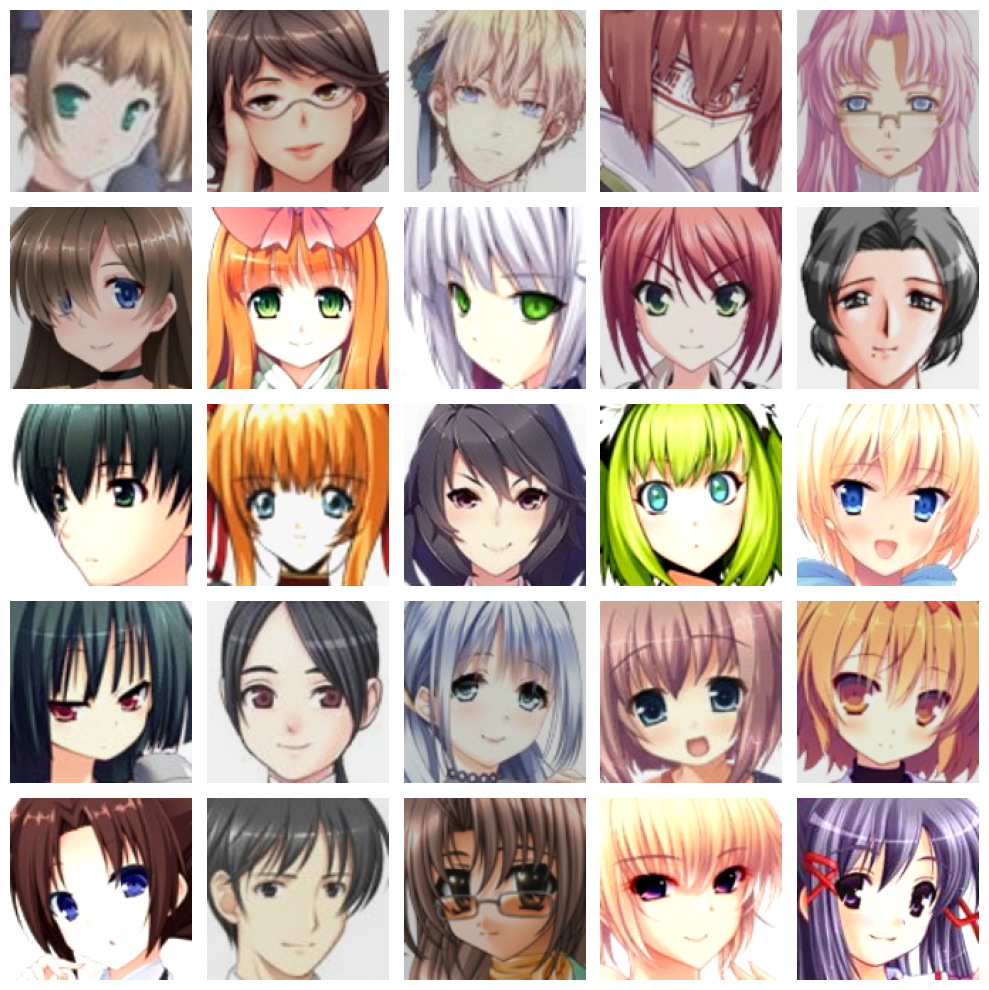

In [4]:
def show_sample_images(dataset, num_images=25):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for ax in axes.flatten():
        img, _ = dataset[random.randint(0, len(dataset)-1)]
        img = img * 0.5 + 0.5  
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(dataset)


#### Self Attention layer

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query(x).view(B, -1, W * H).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, W * H)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, W * H)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(B, C, H, W)
        return self.gamma * out + x


#### Generator with Self-Attention

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3, feature_g=64):
        super().__init__()
        self.net = nn.Sequential(
            self._block(z_dim, feature_g * 8, 4, 1, 0),          
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),  
            SelfAttention(feature_g * 4),
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),  
            self._block(feature_g * 2, feature_g, 4, 2, 1),      
            self._block(feature_g, feature_g // 2, 4, 2, 1),    
            nn.ConvTranspose2d(feature_g // 2, channels, 4, 2, 1),  
            nn.Tanh()
        )

    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)


#### Discriminator with Self-Attention

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels=3, feature_d=64):
        super().__init__()
        self.model = nn.Sequential(
            self._block(channels, feature_d, 4, 2, 1, bn=False),
            self._block(feature_d, feature_d * 2, 4, 2, 1),
            SelfAttention(feature_d * 2),
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),
            self._block(feature_d * 4, feature_d * 8, 4, 2, 1),
            nn.Conv2d(feature_d * 8, 1, 4, 1, 0)
        )

    def _block(self, in_c, out_c, k, s, p, bn=True):
        layers = [nn.Conv2d(in_c, out_c, k, s, p, bias=False)]
        if bn: layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


#### Gradient Penalty

In [8]:
def gradient_penalty(critic, real, fake, device):
    B, C, H, W = real.shape
    epsilon = torch.rand((B, 1, 1, 1), device=device).repeat(1, C, H, W)
    interpolated = real * epsilon + fake * (1 - epsilon)
    mixed_scores = critic(interpolated)
    grad = torch.autograd.grad(
        inputs=interpolated, outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True, retain_graph=True
    )[0]
    grad = grad.view(grad.size(0), -1)
    return ((grad.norm(2, dim=1) - 1) ** 2).mean()


#### Training Setup with 12 epochs

In [9]:
z_dim = 10 
epochs = 12
critic_iterations = 5
lambda_gp = 10

gen = Generator(z_dim=z_dim).to(device)
disc = Discriminator().to(device)

opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.0, 0.9))

scheduler_gen = optim.lr_scheduler.StepLR(opt_gen, step_size=30, gamma=0.5)
scheduler_disc = optim.lr_scheduler.StepLR(opt_disc, step_size=30, gamma=0.5)

fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)
save_dir = "generated_anime_faces"
os.makedirs(save_dir, exist_ok=True)

losses_d, losses_g = [], []

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        real = real.to(device)
        cur_bs = real.size(0)

        for _ in range(critic_iterations):
            noise = torch.randn(cur_bs, z_dim, 1, 1).to(device)
            fake = gen(noise)
            disc_real = disc(real).reshape(-1)
            disc_fake = disc(fake.detach()).reshape(-1)
            gp = gradient_penalty(disc, real, fake, device)
            loss_d = -(disc_real.mean() - disc_fake.mean()) + lambda_gp * gp

            disc.zero_grad()
            loss_d.backward()
            opt_disc.step()

            losses_d.append(loss_d.item())

        noise = torch.randn(cur_bs, z_dim, 1, 1).to(device)
        fake = gen(noise)
        loss_g = -disc(fake).reshape(-1).mean()

        gen.zero_grad()
        loss_g.backward()
        opt_gen.step()
        losses_g.append(loss_g.item())

    scheduler_gen.step()
    scheduler_disc.step()

    print(f"[Epoch {epoch+1}/{epochs}] Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
    with torch.no_grad():
        fake_imgs = gen(fixed_noise).detach().cpu()
        save_image(make_grid(fake_imgs, normalize=True), f"{save_dir}/epoch_{epoch+1:03d}.png")


Epoch 1/12: 100%|████████████████████████████████████████████████████████████████| 1987/1987 [1:14:20<00:00,  2.24s/it]


[Epoch 1/12] Loss D: -0.7623, Loss G: 4.5700


Epoch 2/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:04:22<00:00,  1.94s/it]


[Epoch 2/12] Loss D: -0.7349, Loss G: 5.9757


Epoch 3/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:03:33<00:00,  1.92s/it]


[Epoch 3/12] Loss D: -0.7792, Loss G: 8.1830


Epoch 4/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:00:02<00:00,  1.81s/it]


[Epoch 4/12] Loss D: -0.6341, Loss G: 10.4865


Epoch 5/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:05:01<00:00,  1.96s/it]


[Epoch 5/12] Loss D: -0.9803, Loss G: 12.6075


Epoch 6/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:07:27<00:00,  2.04s/it]


[Epoch 6/12] Loss D: -0.6105, Loss G: 14.8209


Epoch 7/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:17:32<00:00,  2.34s/it]


[Epoch 7/12] Loss D: -0.6652, Loss G: 16.1299


Epoch 8/12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:05:14<00:00,  1.97s/it]


[Epoch 8/12] Loss D: -0.1697, Loss G: 17.1199


Epoch 9/12: 100%|████████████████████████████████████████████████████████████████| 1987/1987 [1:03:58<00:00,  1.93s/it]


[Epoch 9/12] Loss D: -0.4829, Loss G: 18.3591


Epoch 10/12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:04:33<00:00,  1.95s/it]


[Epoch 10/12] Loss D: -0.4760, Loss G: 18.5502


Epoch 11/12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:04:31<00:00,  1.95s/it]


[Epoch 11/12] Loss D: -0.5521, Loss G: 19.7640


Epoch 12/12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [1:04:22<00:00,  1.94s/it]


[Epoch 12/12] Loss D: -0.3811, Loss G: 21.5996


#### Training loop

#### Latent Space Interpolation

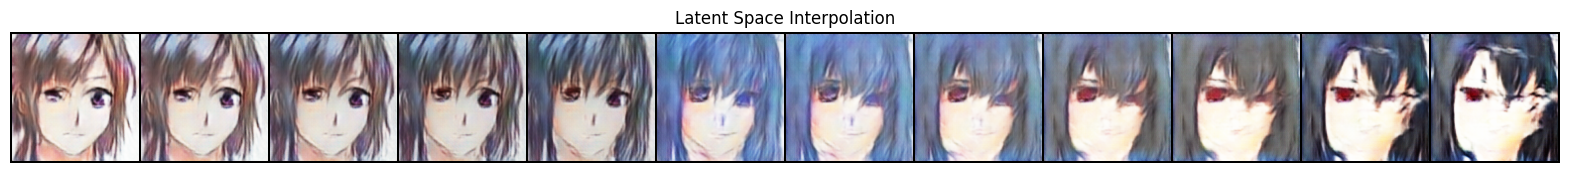

In [10]:
def interpolate(z1, z2, steps=12):
    return [(1 - alpha) * z1 + alpha * z2 for alpha in np.linspace(0, 1, steps)]

z_start = torch.randn(1, z_dim, 1, 1).to(device)
z_end = torch.randn(1, z_dim, 1, 1).to(device)
interpolated = interpolate(z_start, z_end)

gen.eval()
with torch.no_grad():
    imgs = [gen(z).squeeze(0).cpu() for z in interpolated]
    imgs = torch.stack(imgs)
    grid = make_grid(imgs, nrow=len(imgs), normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title("Latent Space Interpolation")
    plt.show()


####  Latent Space Interpolation

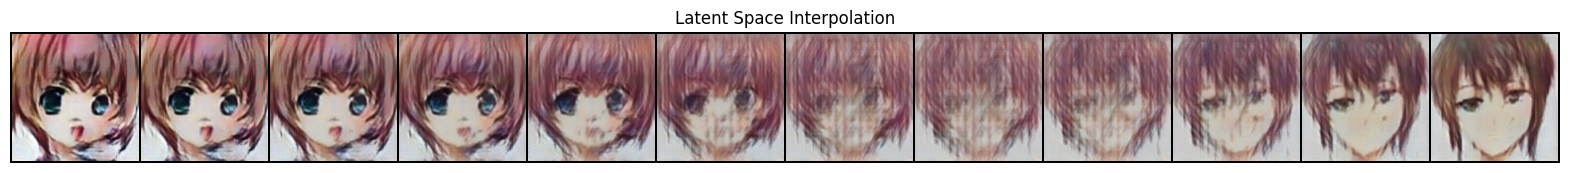

In [11]:
def interpolate(z1, z2, steps=12):
    return [(1 - alpha) * z1 + alpha * z2 for alpha in np.linspace(0, 1, steps)]

z_start = torch.randn(1, z_dim, 1, 1).to(device)
z_end = torch.randn(1, z_dim, 1, 1).to(device)
interpolated = interpolate(z_start, z_end)

gen.eval()
with torch.no_grad():
    imgs = [gen(z).squeeze(0).cpu() for z in interpolated]
    imgs = torch.stack(imgs)
    grid = make_grid(imgs, nrow=len(imgs), normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title("Latent Space Interpolation")
    plt.show()


#### Displaying the 12th epoch result

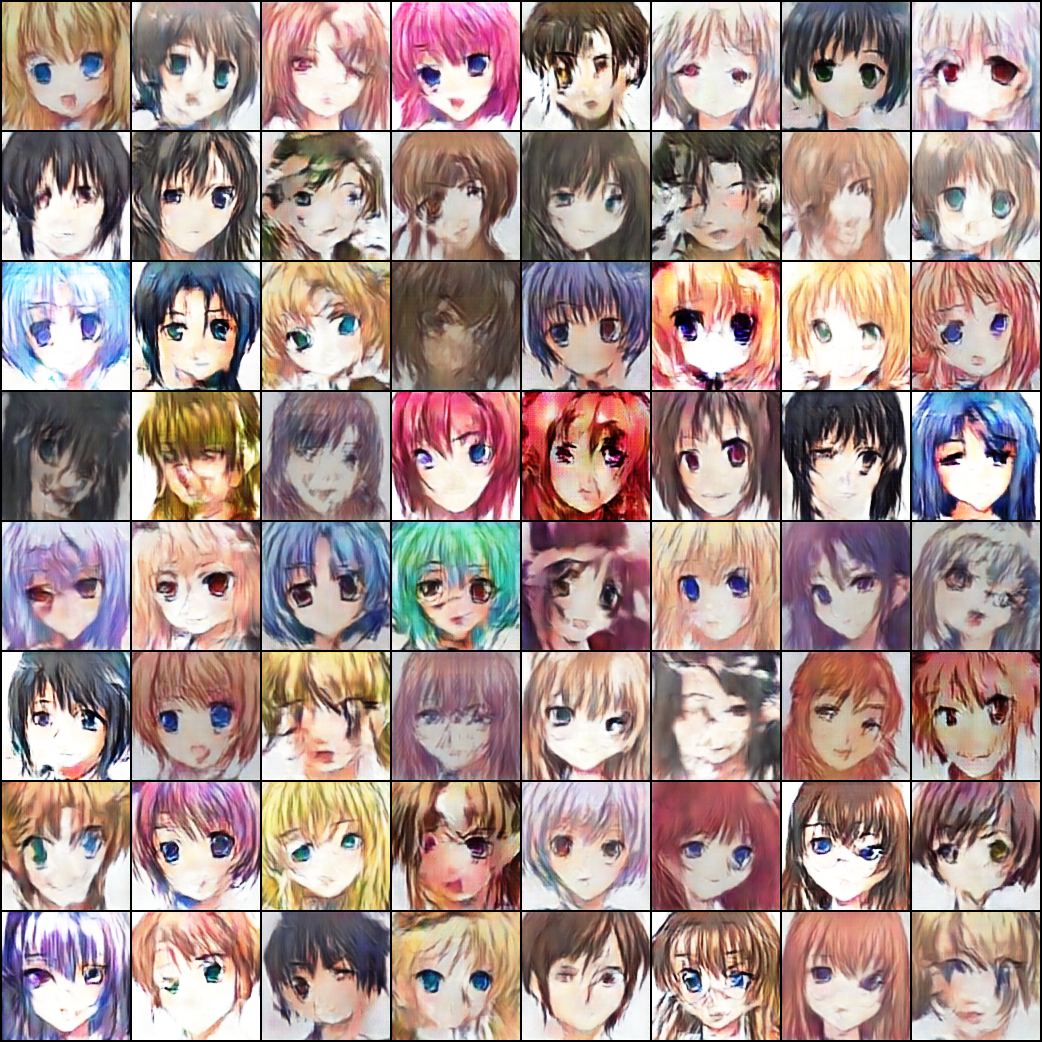

In [12]:
from IPython.display import Image as IPImage, display
display(IPImage(filename=f"{save_dir}/epoch_{epochs:03d}.png"))

### LOSS CUrve generator and discriminator

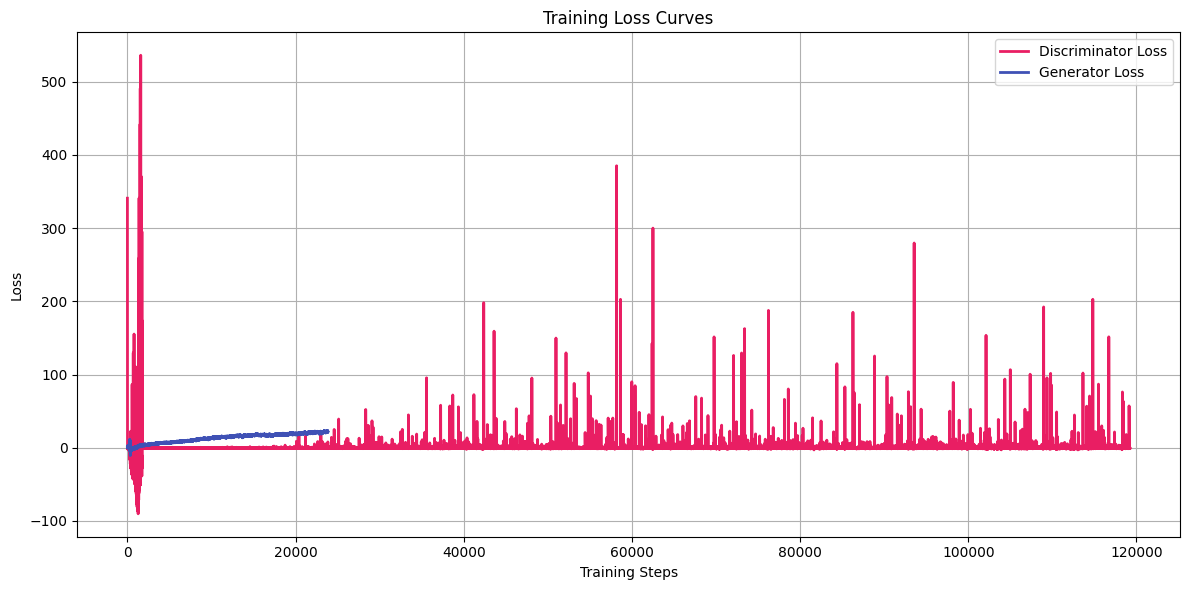

In [13]:
import matplotlib.pyplot as plt

# Plotting generator & discriminator loss curves
plt.figure(figsize=(12, 6))
plt.plot(losses_d, label='Discriminator Loss', color='#E91E63', linewidth=2)
plt.plot(losses_g, label='Generator Loss', color='#3F51B5', linewidth=2)
plt.title('Training Loss Curves')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Creating Fast api server to visualize generated model by calling the API

In [ ]:
# install fast api
!pip install -q fastapi uvicorn nest_asyncio

import nest_asyncio
nest_asyncio.apply()

# imporing libraries fo r fast api
from fastapi import FastAPI
from fastapi.responses import StreamingResponse
import torch
from torchvision.transforms.functional import to_pil_image
import io
import uvicorn

app = FastAPI()

@app.get("/")
def read_root():
    return {"Anime face generator API is running.........."}

@app.get("/generateAnime")
def generate_face():
    z = torch.randn(1, 100, 1, 1).to(device)
    with torch.no_grad():
        img = gen(z)[0].cpu() * 0.5 + 0.5
    pil_img = to_pil_image(img)

    buf = io.BytesIO()
    pil_img.save(buf, format="PNG")
    buf.seek(0)
    return StreamingResponse(buf, media_type="image/png")

#  setting default port 8000
uvicorn.run(app, host="127.0.0.1", port=8000)
